In [1]:
!nvidia-smi
KEY = "yACQGhwtAM5odM5VIp7Q"

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Download your dataset from roboflow using coco format

In [2]:
!pip install roboflow
## You can get this code snipet from roboflow when you are about to download your data
from roboflow import Roboflow
rf = Roboflow(api_key=KEY)
project = rf.workspace("acv-hw4").project("motorbike-detection-copzk")
version = project.version(2)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
## your data should be under /kaggle/working if you are using kaggle notebooks

In [3]:
"Load JSON annotations and put them into one dataframe for easy processing"
import os
import json
import pandas as pd

# Directories to process
# Modify your root directory
root = "motorbike-detection-2"
partitions = ['train', 'test', 'valid']
dataframes = []

for partition in partitions:
    annotation_path = f'{root}/{partition}/_annotations.coco.json'
    if not os.path.exists(annotation_path):
        print(f"⚠️ Skipping missing: {annotation_path}")
        continue

    with open(annotation_path, 'r') as f:
        coco_data = json.load(f)

    # Map image_id to file info
    image_id_to_info = {img["id"]: img for img in coco_data["images"]}

    # Extract annotation rows
    rows = []
    for ann in coco_data["annotations"]:
        image_info = image_id_to_info[ann["image_id"]]
        row = {
            "image_id": ann["image_id"],
            "file_name": image_info["file_name"],
            "bbox": ann["bbox"],
            "category_id": ann["category_id"],
            "partition": partition
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    dataframes.append(df)
# Combine all partitions
full_df = pd.concat(dataframes, ignore_index=True)
full_df[['x', 'y', 'width', 'height']] = pd.DataFrame(full_df['bbox'].tolist(), index=full_df.index)

# Drop the original bbox column for clarity
full_df = full_df.drop(columns=['bbox'])

# Reorder columns for readability
full_df = full_df[['image_id', 'file_name', 'x', 'y', 'width', 'height', 'category_id', 'partition']]

# Now you can group by partition
print(full_df.groupby('partition').size())


partition
test      14
train    266
valid     35
dtype: int64


In [4]:
full_df.head(5)

image_id                                          file_name    x    y  \
0         0  20250315_124809_jpg.rf.dce3b1e0d0923a7fb0f8f53...   49  251   
1         1  IMG-20250315-WA0117_jpg.rf.0c5b2b5c0a537dad708...  157  153   
2         2  20250315_114654_jpg.rf.2227b89731c011a4bfc4ae2...  262  171   
3         2  20250315_114654_jpg.rf.2227b89731c011a4bfc4ae2...  114  177   
4         3  IMG-20250315-WA0129_jpg.rf.13d0b443f40e5a49ad6...  216  186   

   width  height  category_id partition  
0   96.5    95.5            1     train  
1  404.0   482.0            1     train  
2  110.5   129.0            1     train  
3   64.5    83.5            1     train  
4  151.5   133.0            1     train

In [5]:
import cv2
import matplotlib.pyplot as plt
import random

def visualize(image_path, bboxes, labels=None, box_color=(0, 255, 0), text_color=(255, 255, 255), thickness=2):
    """
    image_path: path to image file
    bboxes: list of [x, y, width, height]
    labels: list of label strings (optional)
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for i, (x, y, w, h) in enumerate(bboxes):
        cv2.rectangle(image, (int(x), int(y)), (int(x+w), int(y+h)), box_color, thickness)
        if labels:
            label = labels[i]
            cv2.putText(image, label, (int(x), int(y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Showing train image: 20250315_125452_jpg.rf.980c932bfac0c6291470d8bd0da30fa1.jpg


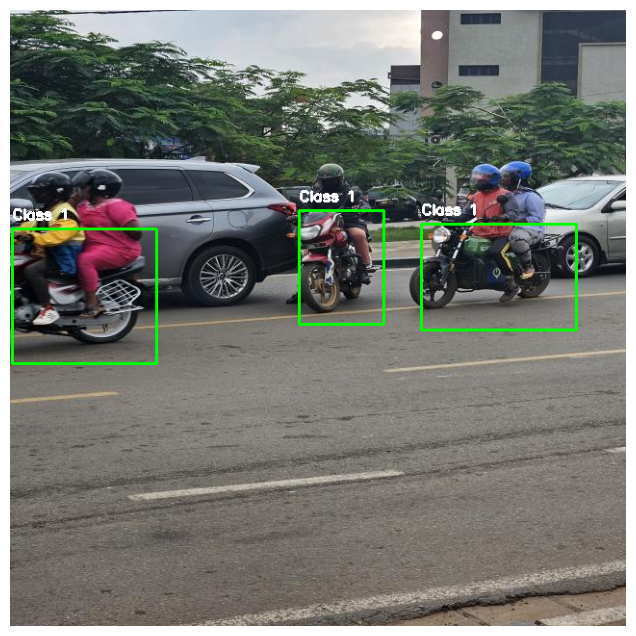

Showing test image: 20250315_125357_jpg.rf.a339021d3036c17760f6751c47823d42.jpg


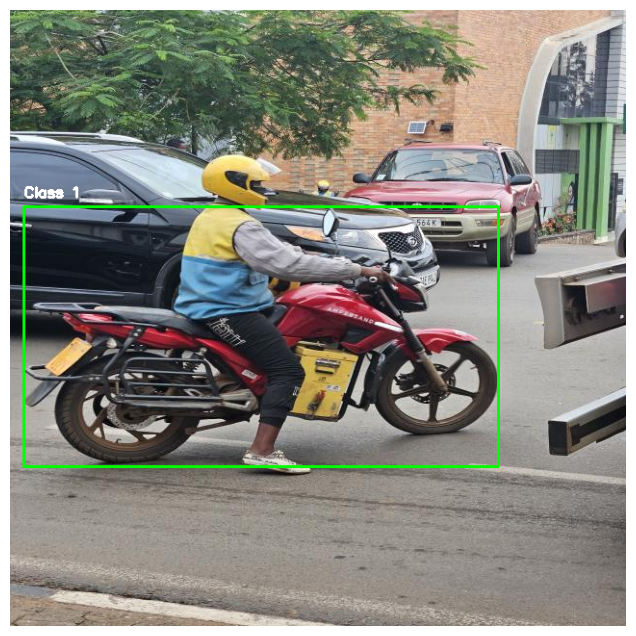

Showing valid image: 20250315_125340_jpg.rf.13bb6020cacb2db448759151eba5f1ce.jpg


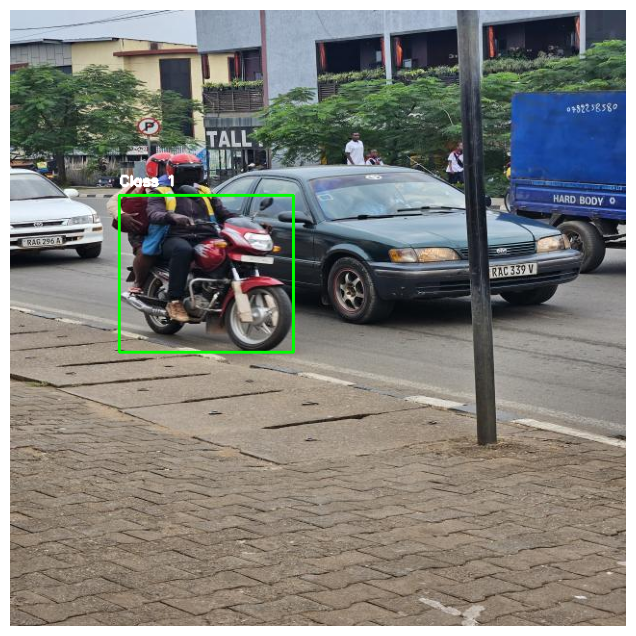

In [6]:
import os

# This assumes images are in the same folder structure as their JSON (train/, test/, valid/)
def visualize_random_from_partition(df, partition, image_base_path=root):
    partition_df = df[df['partition'] == partition]
    if partition_df.empty:
        print(f"No data for partition: {partition}")
        return

    random_image_id = random.choice(partition_df['image_id'].unique())
    rows = partition_df[partition_df['image_id'] == random_image_id]

    image_path = os.path.join(image_base_path, partition, rows.iloc[0]['file_name'])
    bboxes = rows[['x', 'y', 'width', 'height']].values.tolist()
    labels = [f"Class {cid}" for cid in rows['category_id']]

    print(f"Showing {partition} image: {rows.iloc[0]['file_name']}")
    visualize(image_path, bboxes, labels)

visualize_random_from_partition(full_df, "train")
visualize_random_from_partition(full_df, "test" )
visualize_random_from_partition(full_df, "valid")

### Preprocessing step on our images to validate bounding boxes and ensure all images have one orientation

In [7]:
def is_bbox_invalid(bbox, img_w, img_h):
    x, y, w, h = bbox
    # Invalid if any size is non-positive
    if w <= 0 or h <= 0 or x < 0 or y < 0:
        return True
    # Invalid if box goes outside image boundaries
    if (x + w > img_w) or (y + h > img_h):
        return True
    return False
    
def rotate_bbox_90ccw(bbox, img_w, img_h):
    x, y, w, h = bbox
    new_x = y
    new_y = img_w - (x + w)
    return [new_x, new_y, h, w]

In [8]:
invalid_files = []
rotated_count = 0
valid_rows = []
for idx, row in full_df.iterrows():
    bbox = [row['x'], row['y'], row['width'], row['height']]
    image_path = os.path.join(root, row['partition'], row['file_name'])

    if not os.path.exists(image_path):
        print(f"❌ Missing image: {image_path}")
        continue

    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Failed to load image: {image_path}")
        continue

    img_h, img_w = image.shape[:2]

    # Validate bbox
    if is_bbox_invalid(bbox, img_w, img_h):
        
        invalid_files.append(row['file_name'])
        labels = ["Error"]
        bboxes = row[['x', 'y', 'width', 'height']].values.tolist()
        visualize(image_path,[bboxes] , labels)
        continue

    # Rotate landscape image
    if img_w > img_h:
        rotated_img = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        cv2.imwrite(image_path, rotated_img)
    
        new_bbox = rotate_bbox_90ccw(bbox, img_w, img_h)
        full_df.loc[idx, ['x', 'y', 'width', 'height']] = new_bbox
        rotated_count += 1
    valid_rows.append(idx)
print(f"\n✅ Rotated {rotated_count} landscape images.")
print(f"\n❌ Found {len(invalid_files)} invalid bbox images:")
for f in invalid_files:
    print(f"- {f}")


✅ Rotated 0 landscape images.

❌ Found 0 invalid bbox images:


### Remove invalid rows



In [9]:
df_cleaned = full_df.loc[valid_rows].reset_index(drop=True)

### Now we have a dataframe which contains metadata about our images, hence we can proceed to create a Dataset class
There are 3 methods in a dataset class, <br>
\_\_init__,<br>
\_\_len__,<br>
\_\_getitem__ <br>
check out pytorch dataset class https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [10]:
import torch
from torch.utils.data import Dataset
import os
import cv2
import pandas as pd
from PIL import Image

class ObjectDetectionDataset(Dataset):
    def __init__(self, dataframe, image_root_dir, transforms=None):
        """
        dataframe: DataFrame with columns [file_name, x, y, width, height, category_id, partition]
        image_root_dir: base folder path where train/valid/test folders live
        transforms: torchvision transforms to apply to images and targets
        """
        self.df = dataframe
        self.image_root = image_root_dir
        self.transforms = transforms
        self.image_ids = self.df['file_name'].unique()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df['file_name'] == image_id]
        partition = records.iloc[0]['partition']
        image_path = os.path.join(self.image_root, partition, image_id)

        # Load image
        image = Image.open(image_path).convert("RGB")
        w, h = image.size

        # Extract bboxes
        boxes = []
        labels = []
        for _, row in records.iterrows():
            x, y, width, height = row[['x', 'y', 'width', 'height']]
            boxes.append([x, y, x + width, y + height])  # convert to (xmin, ymin, xmax, ymax)
            labels.append(int(row['category_id']))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        image_id_tensor = torch.tensor([idx])

        #Pytorch expects the targets to be in this format
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id_tensor
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target


In [11]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Optional image transforms
# Becareful on what type of augmentations you perform
transform = transforms.Compose([
    transforms.ToTensor()
])


# Filter by partition
df_train = df_cleaned[df_cleaned["partition"] == "train"]
df_valid = df_cleaned[df_cleaned["partition"] == "valid"]
df_test = df_cleaned[df_cleaned["partition"] == "test"]

# Create datasets
train_dataset = ObjectDetectionDataset(df_train, image_root_dir=root, transforms=transform)
valid_dataset = ObjectDetectionDataset(df_valid, image_root_dir=root, transforms=transform)
test_dataset  = ObjectDetectionDataset(df_test,  image_root_dir=root, transforms=transform)

# Define collate function (required by torchvision detection models)
def collate_fn(batch):
    return tuple(zip(*batch))

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=4, shuffle=False, collate_fn=collate_fn)


### Ensure you can load your data correctly and some sanity check with visualizations

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torchvision.transforms.functional as F

def visualize_from_dataloader(loader, num_images=1):
    images, targets = next(iter(loader))

    for i in range(min(len(images), num_images)):
        image_tensor = images[i].cpu()  # shape: (3, H, W)
        image = F.to_pil_image(image_tensor)  # convert to PIL
        image = np.array(image)  # to H x W x C numpy array (RGB)

        # Draw bounding boxes
        boxes = targets[i]['boxes'].cpu().numpy().astype(int)
        labels = targets[i]['labels'].cpu().numpy().tolist()

        for j, (x1, y1, x2, y2) in enumerate(boxes):
            label = f"Class {labels[j]}"
            cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

        # Plot the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Sample {i}")
        plt.axis("off")
        plt.show()


Train Sanity


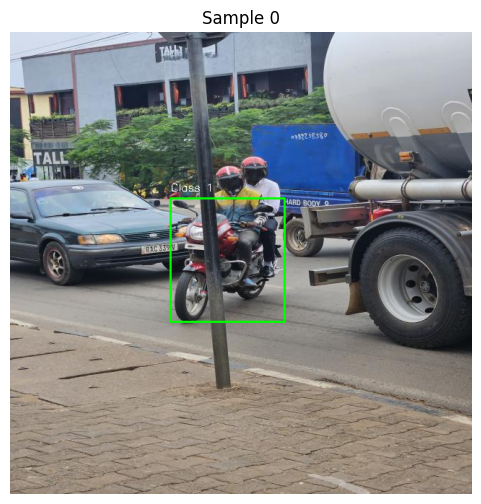

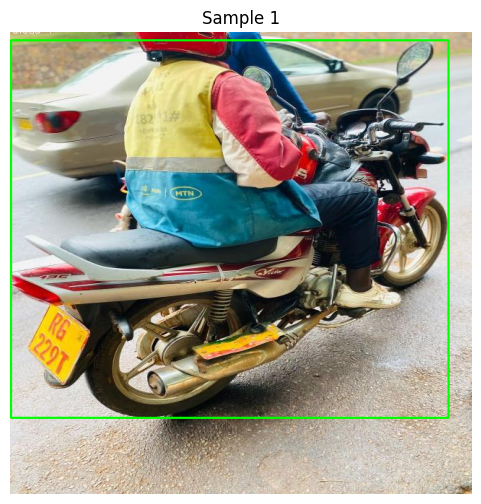

Test Sanity


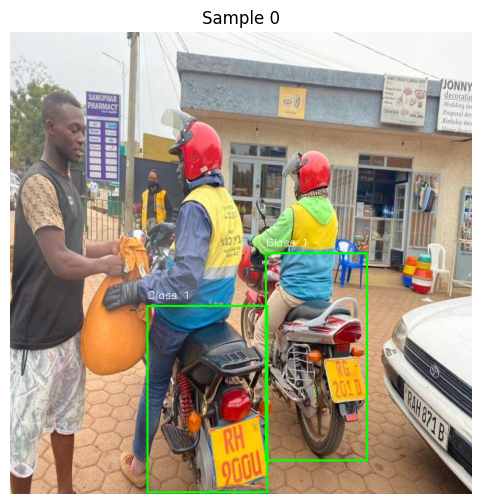

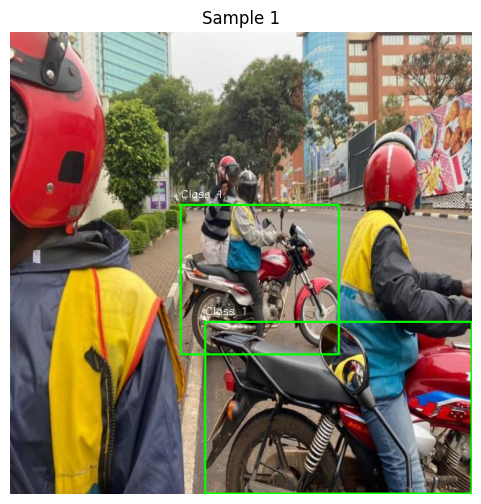

Validation Sanity


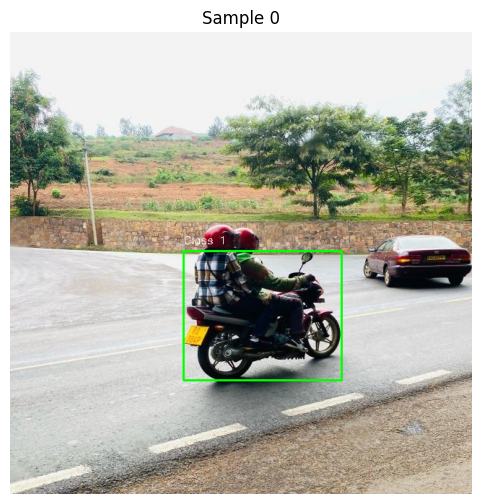

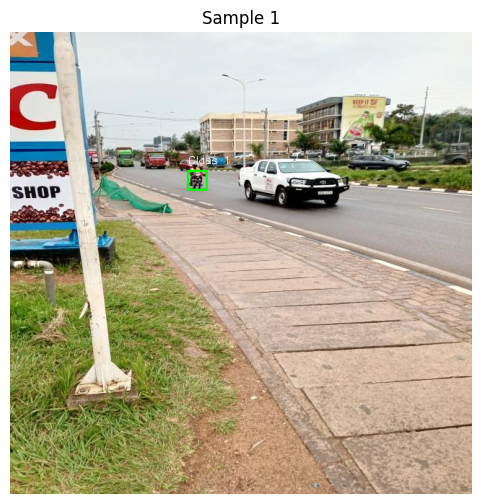

In [13]:
print("Train Sanity")
visualize_from_dataloader( loader=train_loader, num_images=2)
print("Test Sanity")
visualize_from_dataloader( loader=valid_loader, num_images=2)
print("Validation Sanity")
visualize_from_dataloader( loader=test_loader, num_images=2)

### Now we have a dataset class and data loader, we can proceed to define our model

In [ ]:
import torch
import torch.nn as nn

class CustomYOLOv5(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Load pretrained YOLOv5 from PyTorch Hub
        self.wrapper = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=pretrained)
        
        # Access the underlying PyTorch model
        self.backbone = self.wrapper.model  # This is DetectMultiBackend
        # Debug: Inspect structure
        print("Type of self.backbone:", type(self.backbone))
        print("Attributes of self.backbone:", dir(self.backbone))
        
        # Modify the detection head for custom num_classes
        self._replace_head(num_classes)

    def _replace_head(self, num_classes):
        # The DetectMultiBackend's .model is the DetectionModel
        # DetectionModel's .model is the ModuleList, and the last layer is Detect
        detect_layer = self.backbone.model.model[-1]  # Access the Detect module
        
        # Update the number of classes in the Detect module
        detect_layer.nc = num_classes
        
        # Replace convolutional layers in the head for each scale
        for i, m in enumerate(detect_layer.m):
            in_channels = m.in_channels
            # New output channels: num_anchors * (5 + num_classes)
            out_channels = detect_layer.na * (5 + num_classes)  # na = number of anchors per scale
            # Replace the conv layer
            new_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
            detect_layer.m[i] = new_conv

    def forward(self, x, targets=None):
        if self.training and targets is not None:
            # Training mode: run the backbone and compute losses
            preds = self.backbone(x)  # List of predictions for each scale
            # Compute a simple loss (placeholder)
            losses = self._compute_dummy_loss(preds, targets)
            return losses
        else:
            # Inference mode: return raw predictions
            return self.backbone(x)

    def _compute_dummy_loss(self, preds, targets):
        # Placeholder loss; replace with actual YOLOv5 loss for production
        loss = torch.tensor(0.0, device=preds[0].device)
        for pred in preds:
            loss += pred.sum() * 0.01  # Dummy loss based on predictions
        return {"total_loss": loss}

# Instantiate the model
model = CustomYOLOv5(num_classes=2, pretrained=True)
print(model)

Using cache found in /home/ngeyen/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-3-25 Python-3.12.7 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Type of self.backbone: <class 'models.common.DetectMultiBackend'>
Attributes of self.backbone: ['T_destination', '__annotations__', '__call__', '__class__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_metadata', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_

In [ ]:
#Example with RetinaNet, you should modify this class according to your model
#Make sure you explain and overview of the model in you report and its strengths 
import torch
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

class RetinaNetModel(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()

        # Load pretrained RetinaNet
        self.model = retinanet_resnet50_fpn(pretrained=pretrained)

        # Use the known value from RetinaNet (default FPN output channels = 256)
        in_features = 256
        num_anchors = self.model.head.classification_head.num_anchors

        # Replace the classification head with new number of classes
        self.model.head.classification_head = RetinaNetClassificationHead(
            in_channels=in_features,
            num_anchors=num_anchors,
            num_classes=num_classes
        )

    def forward(self, images, targets=None):
        if self.training:
            return self.model(images, targets)
        else:
            return self.model(images)


In [57]:
model = RetinaNetModel(num_classes=2)
print(model)


RetinaNetModel(
  (model): RetinaNet(
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): FrozenBatchNorm2d(256, eps=0.0)
            (relu): ReLU(inplace=True)
            (downsample): Sequential(
              (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), 

### We now have our model ready to be trained. We need to define training params 

In [27]:
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
learning_rate = 1e-4



# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=learning_rate)

# Learning rate Scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Let us connect to weights and biases so we can track our training progress, you will need to create an account on weights and biases obtain an API key for this purpose

In [ ]:
!pip install wandb

In [61]:
import wandb
wandb.login(key="enter your wandb api key")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gzenchaa. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [62]:
wandb.init(
    project="object-detection",   
    name="retinanet-training",    
    config={
        "epochs": num_epochs,
        "lr": learning_rate,
        "batch_size": train_loader.batch_size,
        "model": "retinanet_resnet50_fpn",
        "num_classes": num_classes
    }
)

### Now we are ready to train, so lets create train validate and test functions

In [32]:
from tqdm import tqdm
def train_one_epoch(model, dataloader, optimizer, device, epoch, lr_scheduler=None):
    model.train()
    total_loss = 0

    pbar = tqdm(dataloader, desc=f"[Epoch {epoch}] Training")
    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items() if k != 'image_path'} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

        # wandb.log({"batch_loss": loss.item()})

    avg_loss = total_loss / len(dataloader)
    # wandb.log({
    #     "epoch": epoch,
    #     "avg_train_loss": avg_loss,
    #     "lr": optimizer.param_groups[0]["lr"]
    # })

    if lr_scheduler:
        lr_scheduler.step()

    print(f"✅ Finished Epoch {epoch} | Avg Loss: {avg_loss:.4f}")


In [33]:
from torchvision.ops import box_iou

def validate(model, dataloader, device, epoch):
    model.eval()
    total_iou = 0
    image_count = 0

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc=f"[Epoch {epoch}] Validating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items() if k != 'image_path'} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                if output['boxes'].numel() == 0:
                    continue

                preds = output['boxes'].cpu()
                gts = target['boxes'].cpu()

                ious = box_iou(preds, gts)
                image_iou = ious.max(dim=1).values.mean().item() if ious.numel() > 0 else 0.0

                total_iou += image_iou
                image_count += 1

                #wandb.log({ "val/mean_iou": image_iou })

    avg_iou = total_iou / image_count if image_count > 0 else 0
    #wandb.log({ "epoch": epoch, "val/avg_iou": avg_iou })
    print(f"📊 [Epoch {epoch}] Validation Avg IoU: {avg_iou:.4f}")


In [34]:
def test_model(model, dataloader, device, max_images=10):
    model.eval()
    print("🚀 Running Test Inference")
    with torch.no_grad():
        for i, (images, targets) in enumerate(dataloader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for j, output in enumerate(outputs):
                boxes = output['boxes'].cpu().numpy().astype(int)
                labels = output['labels'].cpu().numpy().tolist()

                image_tensor = images[j].cpu()
                image = F.to_pil_image(image_tensor)
                image_np = np.array(image)

                for k, (x1, y1, x2, y2) in enumerate(boxes):
                    cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(image_np, f"Class {labels[k]}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

                # Log prediction to wandb
                # wandb.log({ "test/prediction": [wandb.Image(image_np, caption=f"Sample {j}")] })

            if i >= max_images:
                break


In [35]:
for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, train_loader, optimizer, device, epoch, lr_scheduler)
    validate(model, valid_loader, device, epoch)

# Run test after training
test_model(model, test_loader, device)

[Epoch 1] Training:   0%|          | 0/42 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'shape'

In [71]:
#To log IOU to Wandb, I call the validate model with test loader, hence last log will be test iou
validate(model, test_loader, device, num_epochs+1)

[Epoch 11] Validating: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

📊 [Epoch 11] Validation Avg IoU: 0.3419


In [72]:
import time

def predict_from_dataloader(model, dataloader, device, score_threshold=0.5, class_names=None, max_images=10):
    model.eval()
    count = 0

    for images, targets in dataloader:
        images = [img.to(device) for img in images]

        for i, img_tensor in enumerate(images):
            if count >= max_images:
                return

            # Timing starts
            start_time = time.time()

            with torch.no_grad():
                output = model([img_tensor])[0]

            # Timing ends
            end_time = time.time()
            inference_time = end_time - start_time
            print(f"🕒 Inference Time (image {count+1}): {inference_time:.4f} sec")

            # Post-process and visualize
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()

            image_np = np.array(F.to_pil_image(img_tensor.cpu()))

            for j in range(len(boxes)):
                if scores[j] < score_threshold:
                    continue
                x1, y1, x2, y2 = boxes[j].astype(int)
                label = f"{class_names[labels[j]]}" if class_names else f"Class {labels[j]}"
                score_text = f"{label}: {scores[j]:.2f}"
                cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image_np, score_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, (255, 255, 255), 1)

            plt.figure(figsize=(6, 6))
            plt.imshow(image_np)
            plt.title(f"Prediction {count+1}")
            plt.axis("off")
            plt.show()

            count += 1


In [ ]:
#modify the threshold and observe your model predictions
#measure the average inference time on a target device
predict_from_dataloader(model, test_loader, device, score_threshold=0.5, class_names=["background", "School bag"])